In [277]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

sobel5_x = np.array([
        [-1, -2,  0,  2,  1],
        [-4, -8,  0,  8,  4],
        [-6, -12, 0, 12,  6],
        [-4, -8,  0,  8,  4],
        [-1, -2,  0,  2,  1]
    ])
sobel5_y = sobel5_x.T

x2 = np.array([
        [-1,  -4,  -6,  -4,  -1],
        [-2, -10, -20, -10,  -2],
        [ 0,   0,   0,   0,   0],
        [ 2,  10,  20,  10,   2],
        [ 1,   4,   6,   4,   1]
    ])
y2 = x2.T

kernels = {
    'sobel_x': np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]]),

    'sobel_y': np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]]),

    'scharr_x': np.array([[-3, 0, 3],
                          [-10, 0, 10],
                          [-3, 0, 3]]),

    'scharr_y': np.array([[-3, -10, -3],
                          [ 0,   0,  0],
                          [ 3,  10,  3]]),

    'sobel5_x': sobel5_x,
    'sobel5_y': sobel5_y,
    'scharr5_x': x2,
    'scharr5_y': y2,
}


In [278]:
def convolve2d(image, kernel):
    """
    Perform 2D convolution operation manually

    Args:
        image: Input 2D numpy array (grayscale image)
        kernel: 2D numpy array representing the convolution kernel

    Returns:
        Convolved image as 2D numpy array
    """
    img = np.array(image).astype(np.float64) / 255.0

    img_height, img_width = img.shape
    kernel_height, kernel_width = kernel.shape

    # Calculate padding needed
    pad_h = kernel_height // 2
    pad_w = kernel_width // 2

    # Creating padded image
    padded_image = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    # Initialize output array
    output = np.zeros_like(image, dtype=np.float64)

    # Perform convolution
    for i in range(img_height):
        for j in range(img_width):

            roi = padded_image[i:i+kernel_height, j:j+kernel_width]
            # Apply kernel and sum
            output[i, j] = np.sum(roi * kernel)

    return output

In [279]:
class EdgeDetector:


    def detect_edges_sobel(self, image):
        """
        Detect edges using Sobel operator

        Args:
            image: Input grayscale image
            blur: Whether to apply Gaussian blur before edge detection

        Returns:
            Dictionary containing gradient magnitudes and directions
        """


        # Apply Sobel kernels
        grad_x = convolve2d(img, kernels['sobel_x'])
        grad_y = convolve2d(img, kernels['sobel_y'])

        # Calculate gradient magnitude and direction
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        direction = np.arctan2(grad_y, grad_x)

        return {
            'magnitude': magnitude,
            'direction': direction
        }

    def sobel5_edge_detection(self, image):
        """
        Perform complete edge detection using 5x5 Sobel operator.

        Args:
            image: Input image

        Returns:
            magnitude and direction of edges
        """

        # Convert to float64 for precision
        img = image.astype(np.float64)/255.0


        # Apply convolution with Sobel kernels
        grad_x = convolve2d(img, kernels['sobel5_x'])
        grad_y = convolve2d(img, kernels['sobel5_y'])

        # Calculate gradient magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Calculate gradient direction
        direction = np.arctan2(grad_y, grad_x)


        return {
            'magnitude': magnitude,
            'direction': direction
        }

    def scharr5_edge_detection(self, image):
        """
        Perform complete edge detection using 5x5 Sobel operator.

        Args:
            image: Input image
            threshold: Threshold value for edge detection (auto-calculated if None)

        Returns:
            Binary edge image
        """

        # Convert to float64 for precision
        img = image.astype(np.float64)/255.0


        # Apply convolution with Sobel kernels
        grad_x = convolve2d(img, kernels['scharr5_x'])
        grad_y = convolve2d(img, kernels['scharr5_y'])

        # Calculate gradient magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Calculate gradient direction
        direction = np.arctan2(grad_y, grad_x)


        return {
            'magnitude': magnitude,
            'direction': direction
        }

    def detect_edges_scharr(self, image):
        """
        Detect edges using Scharr operator (more accurate than Sobel)

        Args:
            image: Input grayscale image

        Returns:
            Dictionary containing gradient magnitudes and directions
        """
        img = image.astype(np.float64) / 255.0

        grad_x = convolve2d(img, kernels['scharr_x'])
        grad_y = convolve2d(img, kernels['scharr_y'])

        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        direction = np.arctan2(grad_y, grad_x)

        return {
            'magnitude': magnitude,
            'direction': direction
        }


    def threshold_edges(self, magnitude, low_threshold, high_threshold):
        """
        Apply double thresholding to edge magnitude

        Args:
            magnitude: Edge magnitude array
            low_threshold: Low threshold value
            high_threshold: High threshold value

        Returns:
            Thresholded binary edge image
        """
        # Normalize magnitude to [0, 1]
        norm_magnitude = magnitude / np.max(magnitude)

        # Create binary edge map
        edges = np.zeros_like(norm_magnitude)
        edges[norm_magnitude > high_threshold] = 1
        # initializing edges with low magnitude to be of lower intensity
        edges[(norm_magnitude > low_threshold) & (norm_magnitude <= high_threshold)] = 0.5

        return edges

    def visualize_results(self, original_image, results, method_name, lt, ht):
        """
        Visualize edge detection results

        Args:
            original_image: Original input image
            results: Dictionary containing edge detection results
            method_name: Name of the edge detection method used
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns
        fig.suptitle(f'Edge Detection Results - {method_name}', fontsize=16)

        axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        thresholded = self.threshold_edges(results['magnitude'], lt, ht)
        axes[1].imshow(thresholded, cmap='gray')
        axes[1].set_title('Thresholded Edges')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()



In [280]:
def apply_gaussian_blur(image, sigma=1.0):
    """
    Apply Gaussian blur to reduce noise before edge detection
    """


    # Create Gaussian kernel
    size = int(2 * np.ceil(3 * sigma) + 1)
    kernel = np.zeros((size, size))
    center = size // 2

    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normalize kernel
    kernel = kernel / np.sum(kernel)

    return convolve2d(image, kernel)

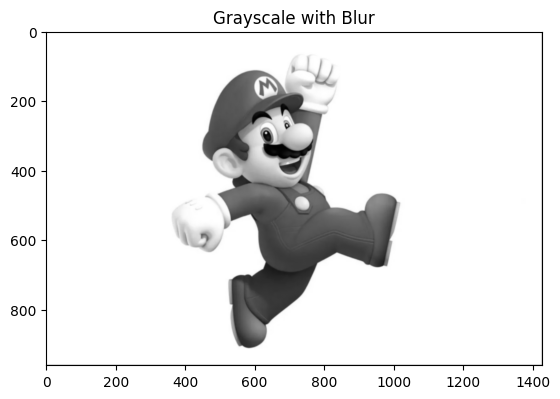

In [281]:
edgedetector = EdgeDetector()


img = Image.open('mario.jpg')
img = img.convert('L')
img_array = np.array(img)
img_array = img_array.astype(np.float64) # Convert to float64 to prevent overflow and precision issues
img_copy = img_array.copy()
img_array = apply_gaussian_blur(img_array, sigma=1.0)

plt.imshow(img_array, cmap = 'gray')
plt.title('Grayscale with Blur')
plt.show()

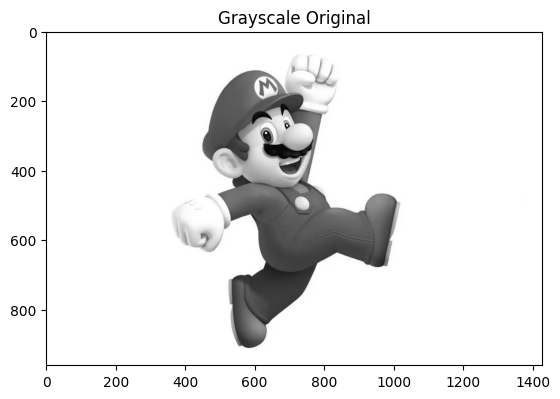

In [282]:
img_color = Image.open('mario.jpg')
img2 = img_color.convert('L')
img_array = np.array(img2)

img_notblur = img_array.copy()
plt.imshow(img_notblur, cmap = 'gray')
plt.title('Grayscale Original')
plt.show()

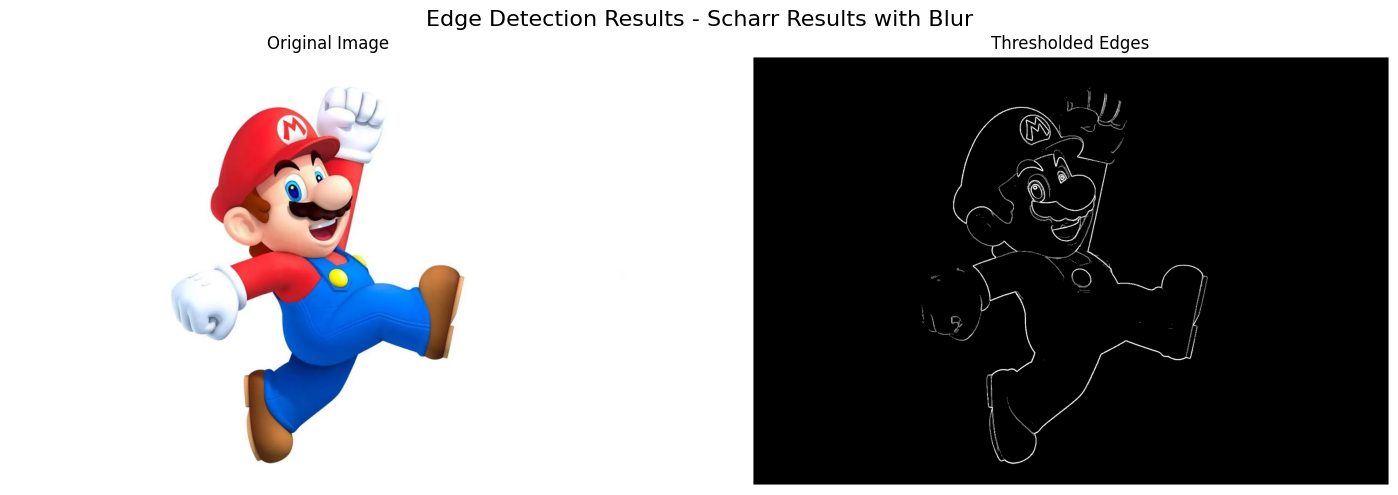

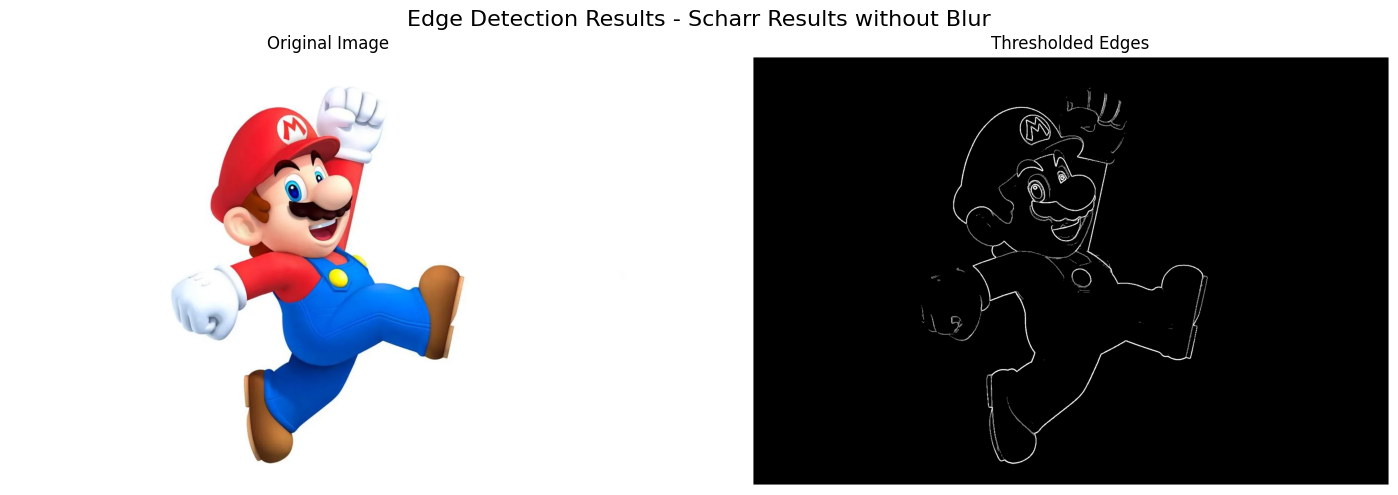

In [283]:
#Applying scharr to both blur and non-blur images


h = 0.3 #High Threshold
l = 0.1 #Low Threshold

scharr_results = edgedetector.detect_edges_scharr(img_array)

scharr_results_notblur = edgedetector.detect_edges_scharr(img_notblur)

edgedetector.visualize_results(img_color, scharr_results, 'Scharr Results with Blur', l, h)

edgedetector.visualize_results(img_color, scharr_results_notblur, 'Scharr Results without Blur', l, h)

As we can see, we get better results if we preprocess the image with gaussian blur, now continuing the process for different filters.

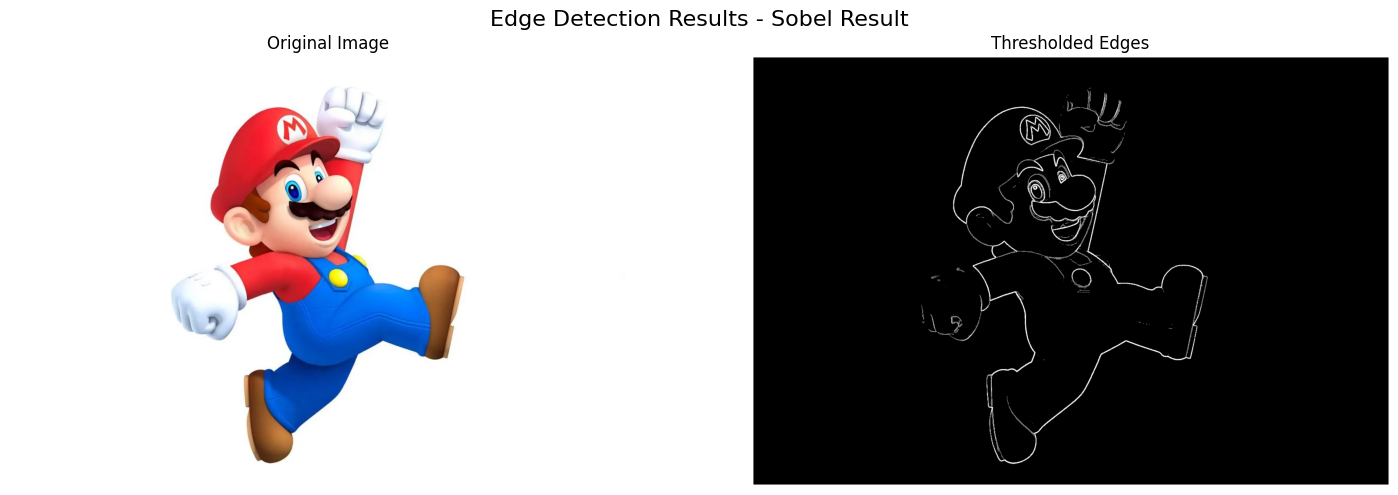

In [284]:
#Sobel
sobel_results = edgedetector.detect_edges_sobel(img_array)

edgedetector.visualize_results(img_color, sobel_results, 'Sobel Result', 0.1, 0.3)

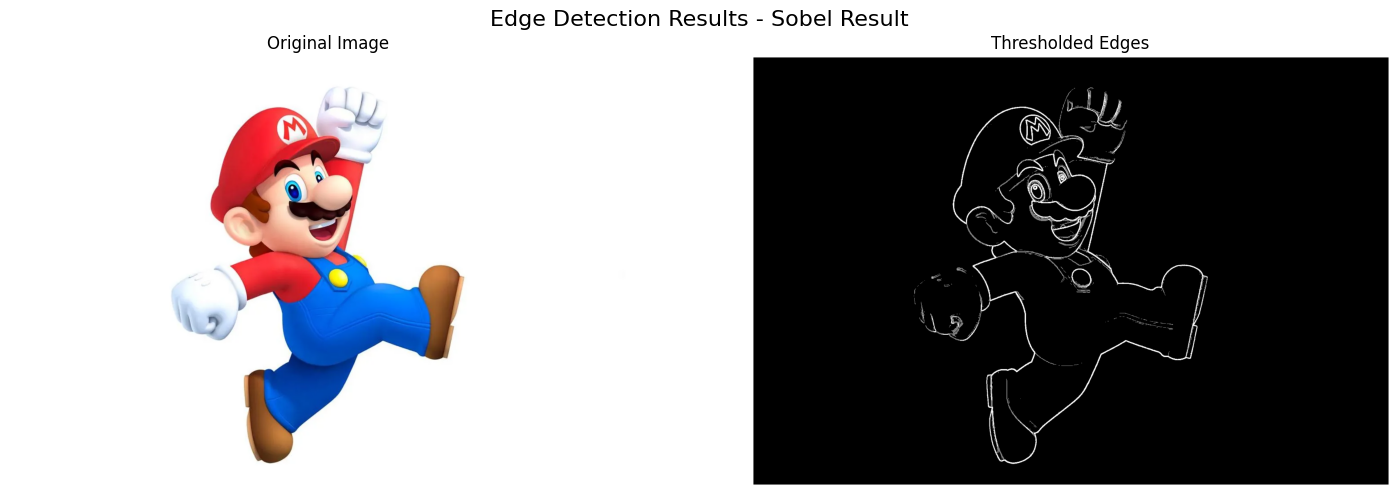

In [285]:
sobel_results = edgedetector.detect_edges_sobel(img_array)

edgedetector.visualize_results(img_color, sobel_results, 'Sobel Result', 0.07, 0.2)

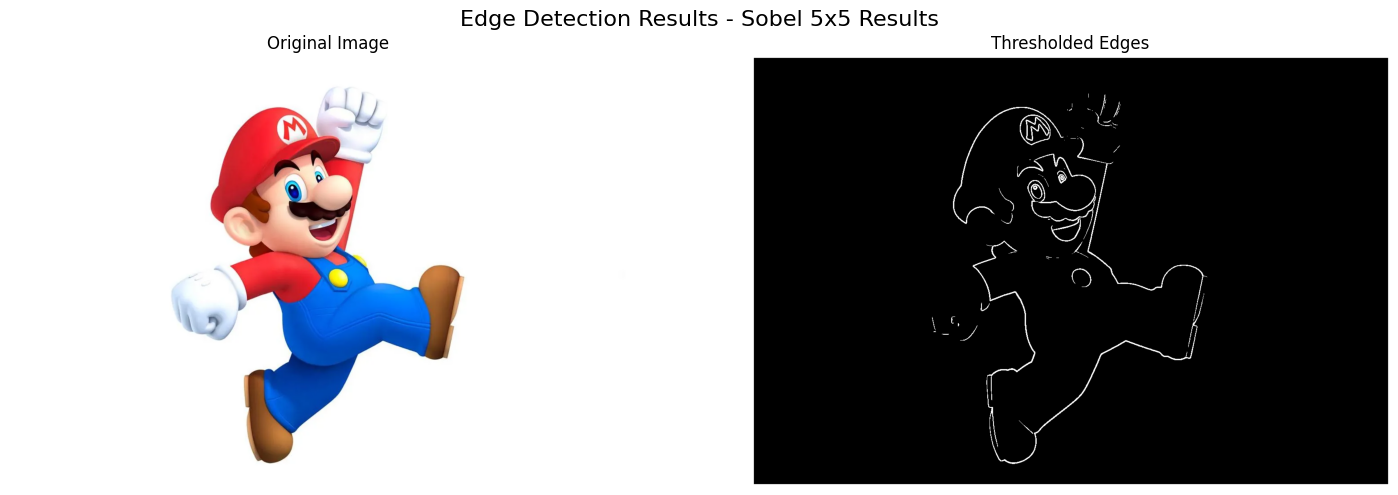

In [286]:
sobel5_results_blur = edgedetector.sobel5_edge_detection(img_array)



edgedetector.visualize_results(img_color, sobel5_results_blur, 'Sobel 5x5 Results', 0.5, 0.25)

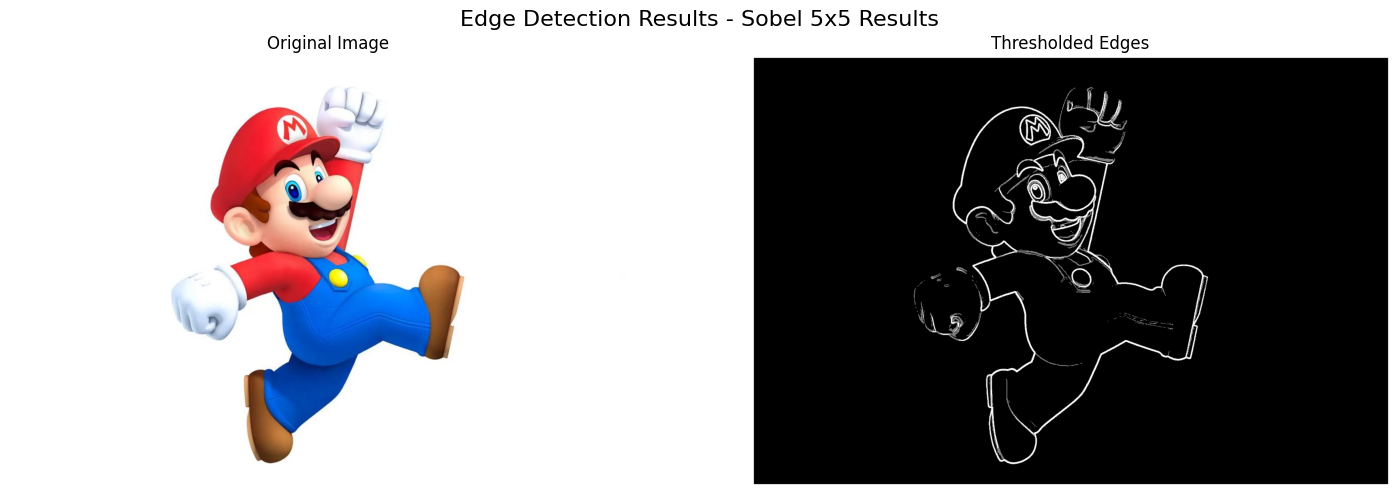

In [287]:
sobel5_results_blur = edgedetector.sobel5_edge_detection(img_array)



edgedetector.visualize_results(img_color, sobel5_results_blur, 'Sobel 5x5 Results', 0.075, 0.2)

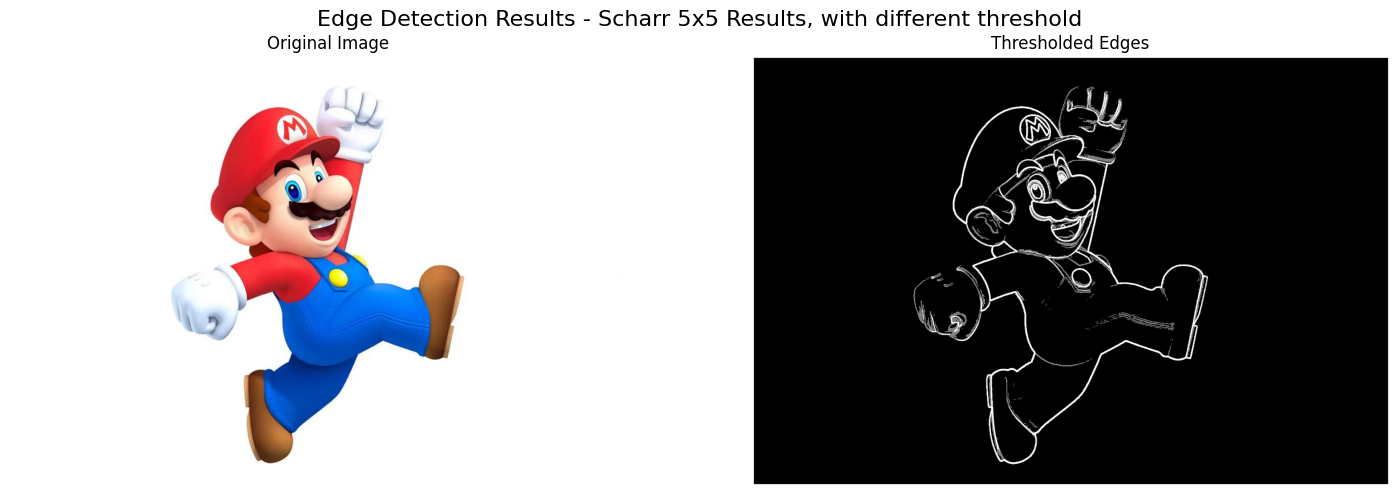

In [288]:
scharr5_results_blur = edgedetector.scharr5_edge_detection(img_array)



edgedetector.visualize_results(img_color, scharr5_results_blur, 'Scharr 5x5 Results, with different threshold', 0.05, 0.15)

We are getting different edge detection for different thresholds and kernels.
I have tweaked the values for threshold and operated for different kernels many times and the one above matches very closely with the requirement of the assignment.